# Project 1: Linear Regression and Model Comparison

### Running necessary libraries 

In [1]:
print('Upgrading PyMC to version 5. This takes about 50 seconds...')
!pip install --ignore-installed llvmlite > /dev/null 2> /dev/null
!pip install --upgrade "pymc>=5,<6" numexpr matplotlib numba > /dev/null 2> /dev/null

import pymc as pm
print(f"We're running PyMC v{pm.__version__} today.")

Upgrading PyMC to version 5. This takes about 50 seconds...
We're running PyMC v5.8.2 today.


In [116]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import pandas as pd
import arviz as az
import scipy.stats as sts
import pytensor.tensor as pt
import warnings
warnings.filterwarnings("ignore")

### Introduction

In this linear regression and model comparison assignment, I explore the relationship between the inflation rate and theft committed in Buenos Aires. As many studies suggested, the crime rate increases following a high inflation rate, which we would test in one of the most extreme cases, considering the high inflation rate of Argentina. I collected the crime rate data from Kaggle and the inflation rate from Statista. The crime data is dated from 2016 to the end of 2021, while the inflation rate data is from 2018 to 2023. Thus, we are running our analysis from 2018 to the end of 2021. 



Crime data in Buenos Aires: https://www.kaggle.com/datasets/federicocardenes/crimes-in-buenos-aires-2021-2016
Inflation rate monthly link: https://www.statista.com/statistics/1320016/monthly-inflation-rate-argentina/#:~:text=In%20Argentina%2C%20the%20CPI%20in,least%2C%20the%20beginning%20of%202018.

### Data processing

In [184]:
### Importing the data
crime_data = pd.read_csv('/Users/billy/Desktop/crimes_buenos_aires_2021_2016.csv')
crime_data.head()

,Unnamed: 0,Date,Time Zone,Category,Subcategory,Weapons Involved,District,Commune,Latitude,Longitude,Victims
0,0,2021-06-01,18,homicide,road accident,UNKNOWN,Constitución,1.0,"-34,62761","-58,379146",1.0
1,1,2021-07-01,10,homicide,road accident,UNKNOWN,Mataderos,9.0,"-34,64972969","-58,51058958",1.0
2,2,2021-10-01,7,homicide,road accident,UNKNOWN,Parque Chacabuco,7.0,"-34,62917196","-58,43058079",1.0
3,3,2021-11-01,9,homicide,road accident,UNKNOWN,Nueva Pompeya,5.0,"-34,63867577","-58,4145554",1.0
4,4,2021-11-01,21,homicide,road accident,UNKNOWN,Parque Avellaneda,9.0,"-34,64771436","-58,46806552",1.0


***Crime data***

In this code cell, we are counting the number of theft (violent and non-violent) from 2018 to 2021. 

In [5]:
crime_data['Date'] = pd.to_datetime(crime_data['Date'])

condition1 = (crime_data['Category'] == 'theft (non-violent)') | (crime_data['Category'] == 'theft (violent)') 

result = crime_data[condition1].groupby(crime_data['Date'].dt.to_period('M')).size()

result = result.reset_index()
result.columns = ['Month', 'Count']
result = result.drop(result.index[:24])

***Inflation rate data*** 

Here, I copied each month's inflation rate from the Statista link from 2018 to 2021 and added a new column in the "result" data frame. (Statista is not free, so I had to directly copy from the website instead of downloading and uploading a csv file.)

In [66]:
inflation_rate = np.array([25,25.4,25.4,25.5,26.3,29.5,31.2,34.4,40.5,45.9,48.5,47.6,49.3,51.3,54.7,55.8, 57.3, 55.8,54.5, 
                  54.5, 53.5,50.5, 52.1, 53.8, 52.9, 50.3, 48.4, 45.6, 43.4, 42.8, 42.4,40.7, 36.6, 37.2, 35.8, 36.1, 
                  38.5,40.7, 42.6, 46.3, 48.8, 50.2,51.8, 51.4, 52.5, 52.1, 51.2, 50.9])

result['Inflation'] = inflation_rate


In this case, I decided to normalize the two variables using z-score normalization because we have different units for inflation and a number of thefts. Even though, without normalization, we would get the same results, the visualizations were better with normalized variables. 

In [67]:
# We are ordering the data because it makes the posterior predictive samples 
# more smooth. 

data_x = np.array(result['Inflation'])
order = np.argsort(data_x)
data_x = data_x[order]
data_y = np.array(result['Count'])[order]


data_x_std = (data_x - data_x.mean()) / data_x.std()
data_y_std = (data_y - data_y.mean()) / data_y.std()

***This code is modified from: "CS146 Session 12 - [7.1] Model comparison 3: Practice - 
Model comparison workbook 3 - Linear regression on obesity data"***

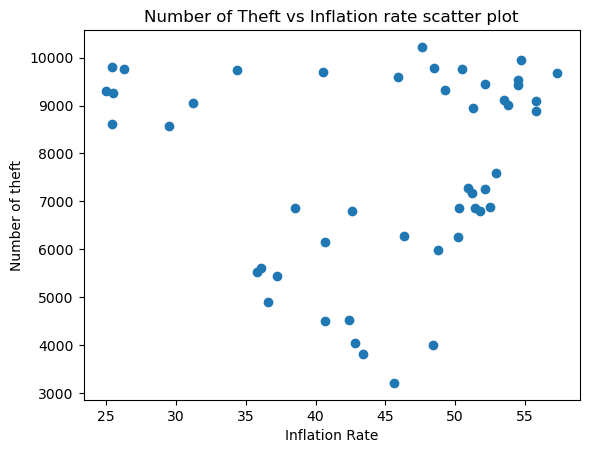

In [68]:
plt.scatter(data_x, data_y)
plt.xlabel('Inflation Rate')
plt.ylabel('Number of theft')
plt.title('Number of Theft vs Inflation rate scatter plot')
plt.show()

Here is our visualization of the data. Although the scatter plot does not look correlated, we would continue our analysis and try to discover their correlation. 

### Linear Regression Analysis

Now we have the data; we will continue our analysis by considering different models: Normal, Student T, and Outlier detector. We are running some functions below to calculate lppd for each inference and plot posterior predictive HDI for different degrees of the model. 

In [128]:
def lppd(inference):
    from scipy.special import logsumexp
    
    # Get all the log p(y_i | theta_s) values from the PyMC sampler. The
    # shape of the result array is (num_samples, num_data).
    log_posterior_predictive = list(
        inference.
        log_likelihood.
        stack(sample=('chain', 'draw')).
        transpose('sample', ...).values())[0].values

    # Compute the log of the average over the posterior samples, theta_j
    # using logsumexp which computes log(sum(exp(values))) in a numerically
    # stable way.
    individual_lppd = (
        logsumexp(log_posterior_predictive, axis=0) -
        np.log(log_posterior_predictive.shape[0]))

    # Compute the LPPD as the sum over all the data.
    total_lppd = np.sum(individual_lppd)
    
    return total_lppd, individual_lppd


    
def plot_posterior_predictive_hdi(inference):
    plt.figure(figsize=(8, 6))
    plt.title('Posterior and posterior-predictive distributions')
    az.plot_hdi(
        data_x_std, inference.posterior_predictive.likelihood,
        hdi_prob=0.95, smooth=False, color='C1',
        fill_kwargs={'alpha': 0.2, 'label': 'posterior-predictive 95% HDI'})
    plt.plot(
        data_x_std, inference.posterior.mu.median(dim=['chain', 'draw']).values,
        color='C1', alpha=1, label='posterior $\mu$ median')
    
    weights = az.loo(inference, pointwise=True).loo_i.values
    alpha = 1 - 0.95 * (weights - weights.min()) / (weights.max() - weights.min())
    plt.scatter(data_x_std, data_y_std, alpha=alpha, color='C0', label='data with pointwise LOO')
    
    plt.xlabel('Normalized Inflation Rate')
    plt.ylabel('Normalized Number of theft')
    plt.legend()

***This code is modified from: "CS146 Session 12 - [7.1] Model comparison 3: Practice - 
Model comparison workbook 3 - Linear regression on obesity data"***

### Fitting different models with different degrees 

I run an analysis for each likelihood model until the degree of 6. The reason is that, with a small sample size, it is more likely to overfit if we increase the degree. We want to avoid overfitting; the deviance would suggest the same thing regardless. For each model, we are fitting the model using PYMC for different degrees, calculating lppds, and sampling posterior predictive. 

***Normal likelihood model***

In [84]:
degrees = range(1,7)
normal_lppds = []
normal_inferences = []
for degree in degrees:
    with pm.Model() as model:
        
        x = pm.MutableData('x', data_x_std)
        y = pm.MutableData('y', data_y_std)
        
        sigma = pm.HalfNormal('sigma', sigma=1)
        
        alpha = pm.Normal('alpha', mu=0, sigma=1)
        beta = pm.Normal('beta', size=degree, mu=0, sigma=1)
        mu = alpha
        for i in range(1, degree + 1):
            mu = mu + beta[i-1] * x ** i
        
        mu = pm.Deterministic('mu', mu)
        
        likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
        
        inference = pm.sample(progressbar=False)
        
        pm.compute_log_likelihood(inference)
        pm.sample_posterior_predictive(inference, extend_inferencedata=True)

        normal_inferences.append(inference)
        normal_lppds.append(lppd(inference)[0])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [likelihood]


***Student T likelihood model***

In [99]:
t_lppds = []
t_inferences = []
for degree in degrees:
    with pm.Model() as model:
        x = pm.MutableData('x', data_x_std)
        y = pm.MutableData('y', data_y_std)
        
        sigma = pm.HalfNormal('sigma', sigma=1)
        nu = pm.HalfNormal('nu', sigma=1)
        
        alpha = pm.Normal('alpha', mu=0, sigma=1)
        beta = pm.Normal('beta', size=degree, mu=0, sigma=1)
        mu = alpha
        for i in range(1, degree + 1):
            mu = mu + beta[i-1] * x ** i
        
        mu = pm.Deterministic('mu', mu)
        likelihood = pm.StudentT('likelihood',nu = nu, mu=mu, sigma=sigma, observed=y)
        
        inference = pm.sample(progressbar=False)
        

        pm.compute_log_likelihood(inference)
        pm.sample_posterior_predictive(inference, extend_inferencedata=True)

        t_inferences.append(inference)
        t_lppds.append(lppd(inference)[0])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, alpha, beta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, alpha, beta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, alpha, beta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, alpha, beta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, alpha, beta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, alpha, beta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [likelihood]


***Outlier detector likelihood model***

In [159]:
degrees = range(1, 7)
outlier_lppds = []
outlier_inferences = []
for degree in degrees:
    with pm.Model() as model:
        x = pm.MutableData('x', data_x_std)
        y = pm.MutableData('y', data_y_std)
        
        sigma = pm.HalfNormal('sigma', sigma=1)
        sigma_out = pm.HalfNormal('sigma_out', sigma=30)
        sigmas = pt.as_tensor_variable([sigma, sigma + sigma_out])
        
        p = pm.Uniform('p', lower=0, upper=0.5)
        is_outlier = pm.Bernoulli('is_outlier', p=p, size=x.shape[0])
        
        alpha = pm.Normal('alpha', mu=0, sigma=1)
        beta = pm.Normal('beta', size=degree, mu=0, sigma=1)
        
        mu = alpha
        for i in range(1, degree + 1):
            mu = mu + beta[i-1] * x ** i
        
        mu = pm.Deterministic('mu', mu)
        likelihood =  pm.Normal('likelihood', mu=mu, sigma=sigmas[is_outlier], observed=y)

        #We have higher draws and tunes here, which I would explain in diagnostics section. 
        inference = pm.sample(draws = 4000, tune = 4000, progressbar=False)
        
        pm.compute_log_likelihood(inference)
        pm.sample_posterior_predictive(inference, extend_inferencedata=True)


        outlier_inferences.append(inference)
        outlier_lppds.append(lppd(inference)[0])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, sigma_out, p, alpha, beta]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 16 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [likelihood]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, sigma_out, p, alpha, beta]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [likelihood]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, sigma_out, p, alpha, beta]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 19 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [likelihood]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, sigma_out, p, alpha, beta]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 670 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [likelihood]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, sigma_out, p, alpha, beta]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 50 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 388 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [likelihood]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, sigma_out, p, alpha, beta]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 85 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1619 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [likelihood]


***Sampler Diagnostics***

Before analyzing which model works better, we need to test whether our PYMC samplers work as expected for each model. I plotted a rank plot and summary from each of the three models. We can plot the diagnostics for 18 models (3 different models with six different degrees, a total of 18), but it will take a lot of space here. (We can change the degrees from 1 to 6 and get the corresponding rank plot and summary.)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.683,0.217,-1.094,-0.281,0.005,0.003,2046.0,2390.0,1.0
beta[0],0.736,0.368,0.083,1.478,0.009,0.007,1565.0,2004.0,1.0
beta[1],0.701,0.544,-0.285,1.762,0.015,0.011,1261.0,1796.0,1.0
beta[2],-0.406,0.452,-1.259,0.423,0.013,0.009,1276.0,1577.0,1.0
beta[3],0.036,0.299,-0.539,0.596,0.008,0.006,1253.0,1836.0,1.0
beta[4],0.111,0.162,-0.188,0.412,0.005,0.003,1173.0,1639.0,1.0
sigma,0.837,0.093,0.669,1.014,0.002,0.001,2459.0,1933.0,1.0


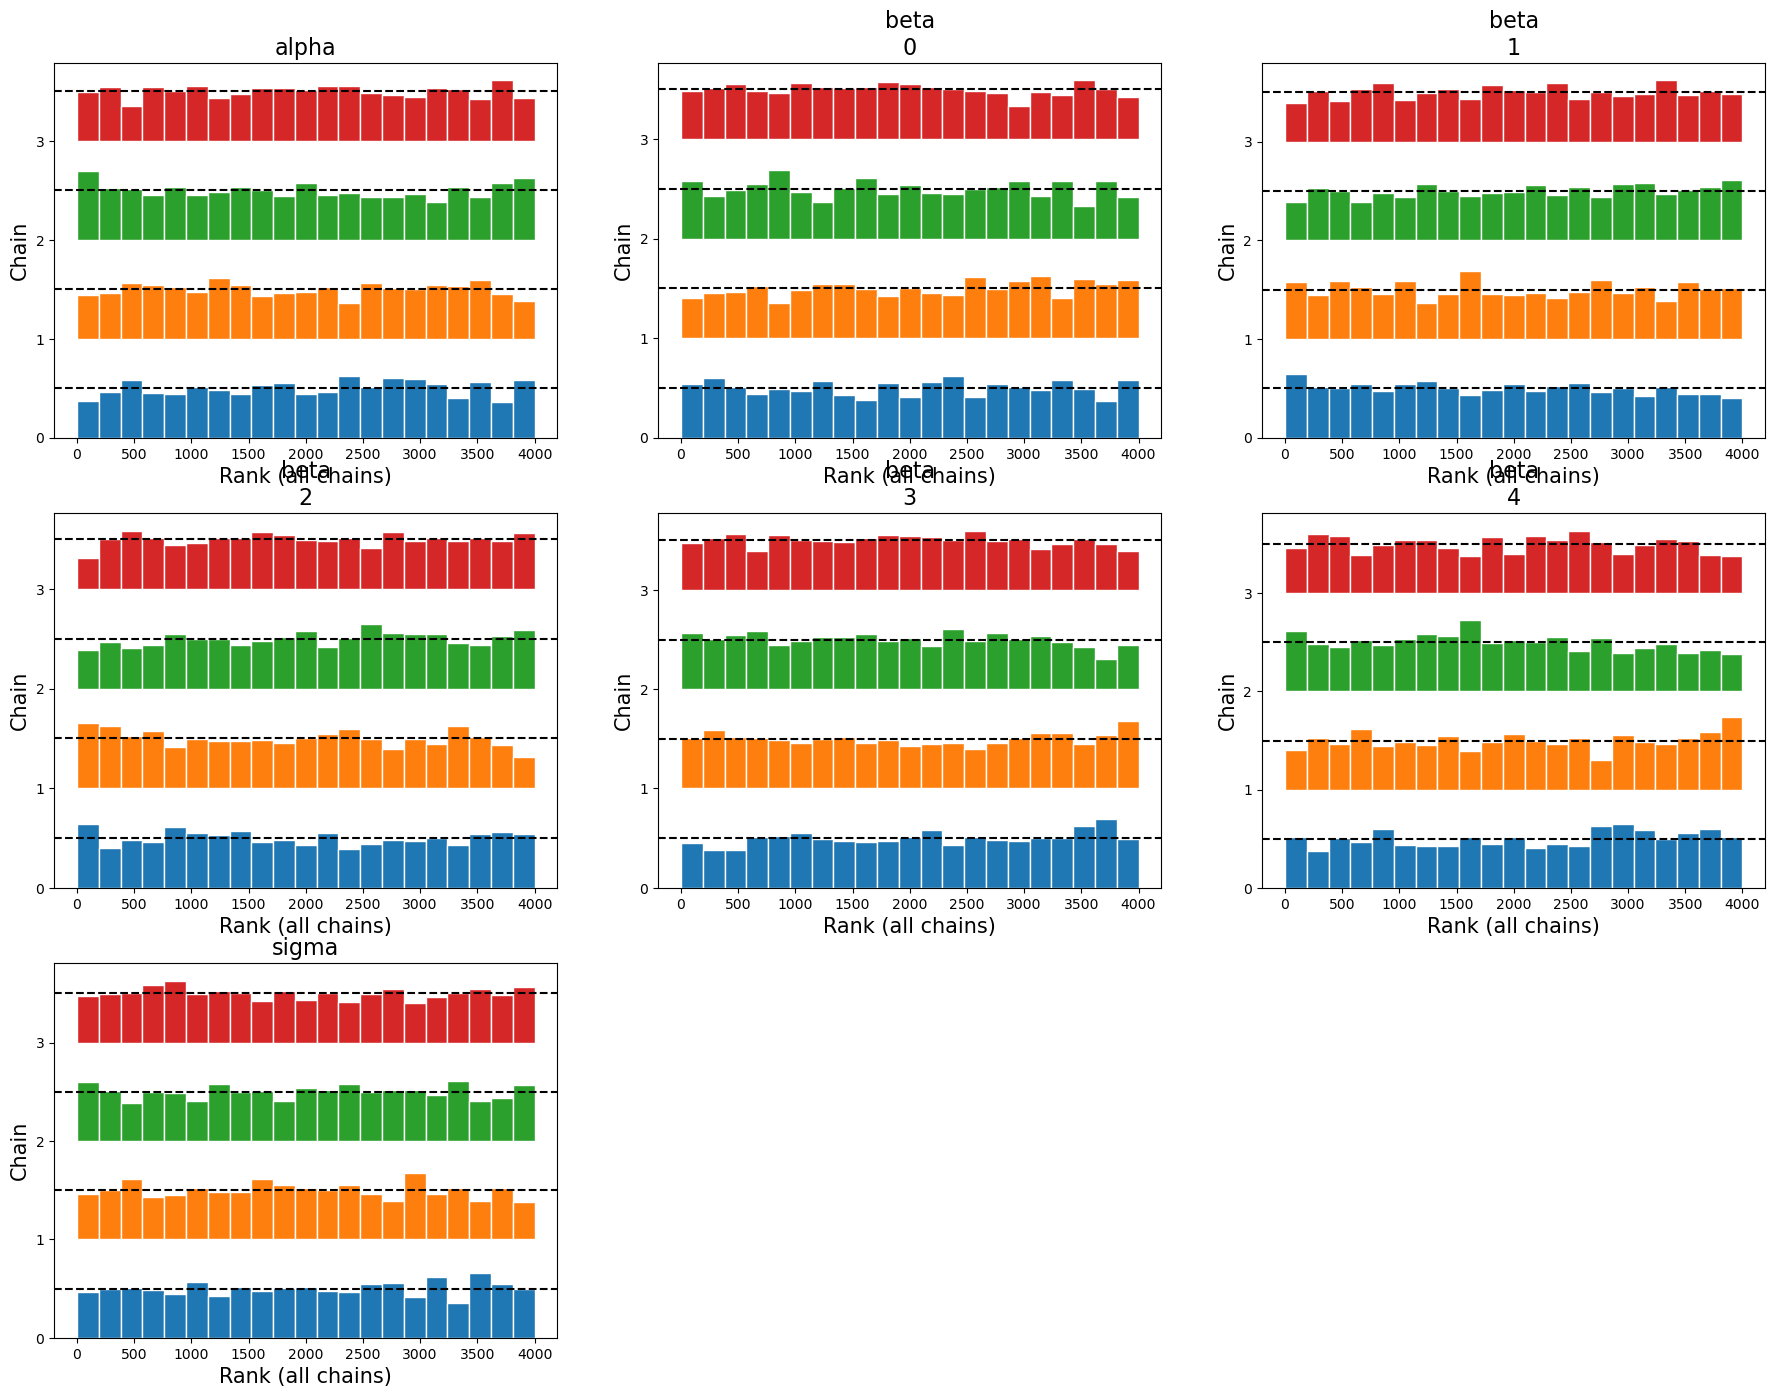

In [145]:
degree = 5
varnames = ["~mu"]  # all variables except mu
az.plot_rank(normal_inferences[degree-1], varnames)
az.summary(normal_inferences[degree-1], varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.023,0.278,-1.583,-0.545,0.012,0.009,489.0,651.0,1.00
beta[0],0.617,0.392,-0.108,1.353,0.012,0.008,1069.0,1706.0,1.01
beta[1],0.735,0.602,-0.306,1.927,0.022,0.015,763.0,1522.0,1.00
beta[2],0.179,0.675,-1.146,1.342,0.028,0.020,577.0,1497.0,1.01
beta[3],0.341,0.428,-0.461,1.137,0.017,0.012,658.0,1412.0,1.01
beta[4],-0.170,0.290,-0.678,0.377,0.014,0.010,428.0,839.0,1.01
beta[5],-0.143,0.133,-0.387,0.102,0.007,0.005,414.0,669.0,1.01
sigma,0.512,0.114,0.297,0.740,0.007,0.005,267.0,58.0,1.01
nu,1.887,0.559,0.800,2.890,0.026,0.019,338.0,111.0,1.01


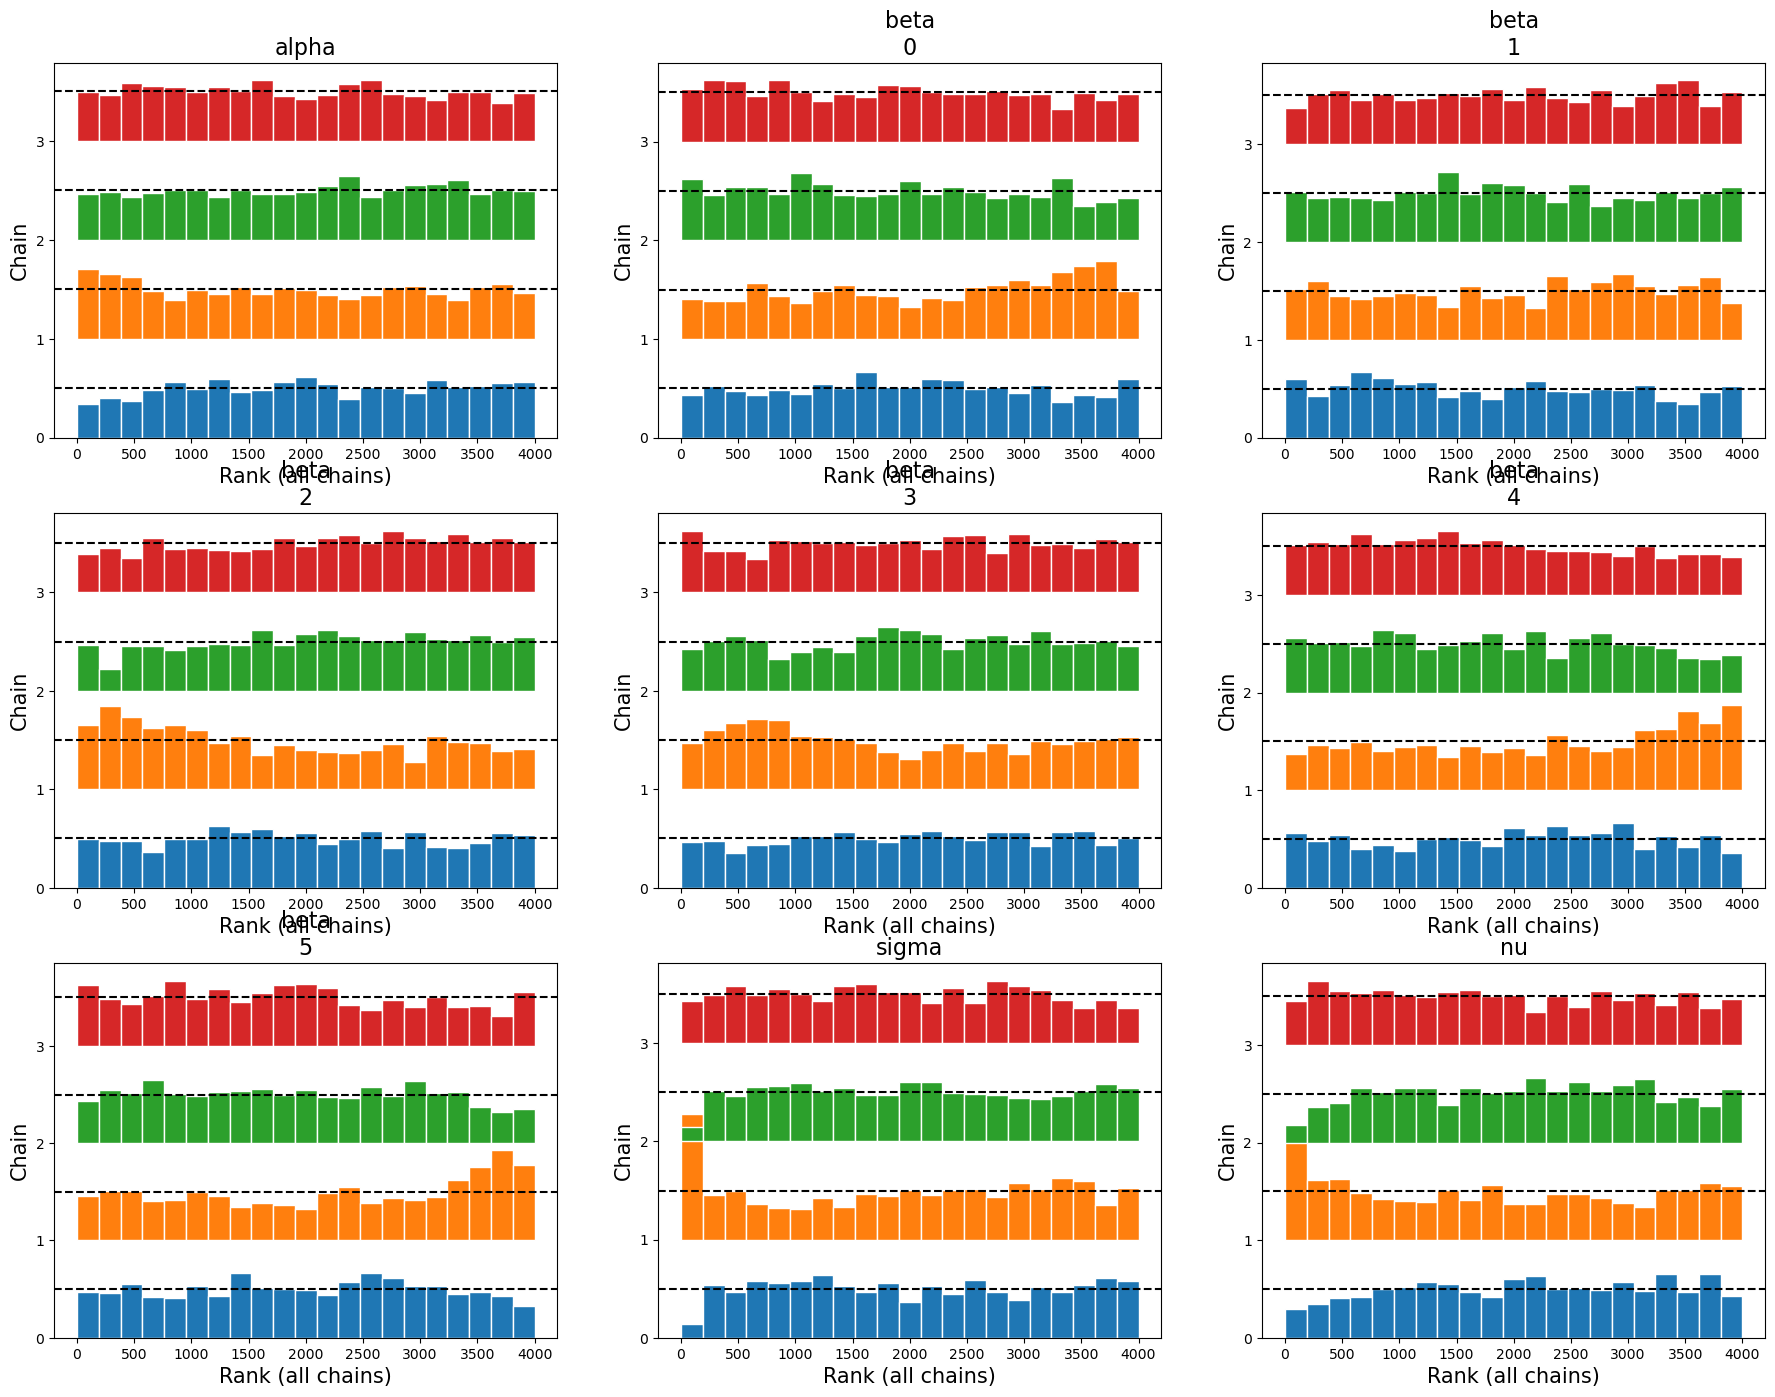

In [164]:
degree = 6
varnames = ["~mu"]  # all variables except mu
az.plot_rank(t_inferences[degree - 1], varnames)
az.summary(t_inferences[degree - 1], varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.660,0.195,-1.016,-0.284,0.004,0.003,2610.0,3303.0,1.00
beta[0],0.466,0.272,-0.058,0.969,0.004,0.003,4877.0,6753.0,1.00
beta[1],0.677,0.216,0.272,1.082,0.003,0.002,3974.0,5887.0,1.00
beta[2],0.028,0.146,-0.246,0.307,0.002,0.002,4129.0,5530.0,1.00
sigma,0.803,0.122,0.552,1.040,0.005,0.003,823.0,548.0,1.00
sigma_out,15.468,18.032,0.000,50.081,0.569,0.403,520.0,2222.0,1.01
p,0.092,0.132,0.000,0.405,0.008,0.006,401.0,846.0,1.01


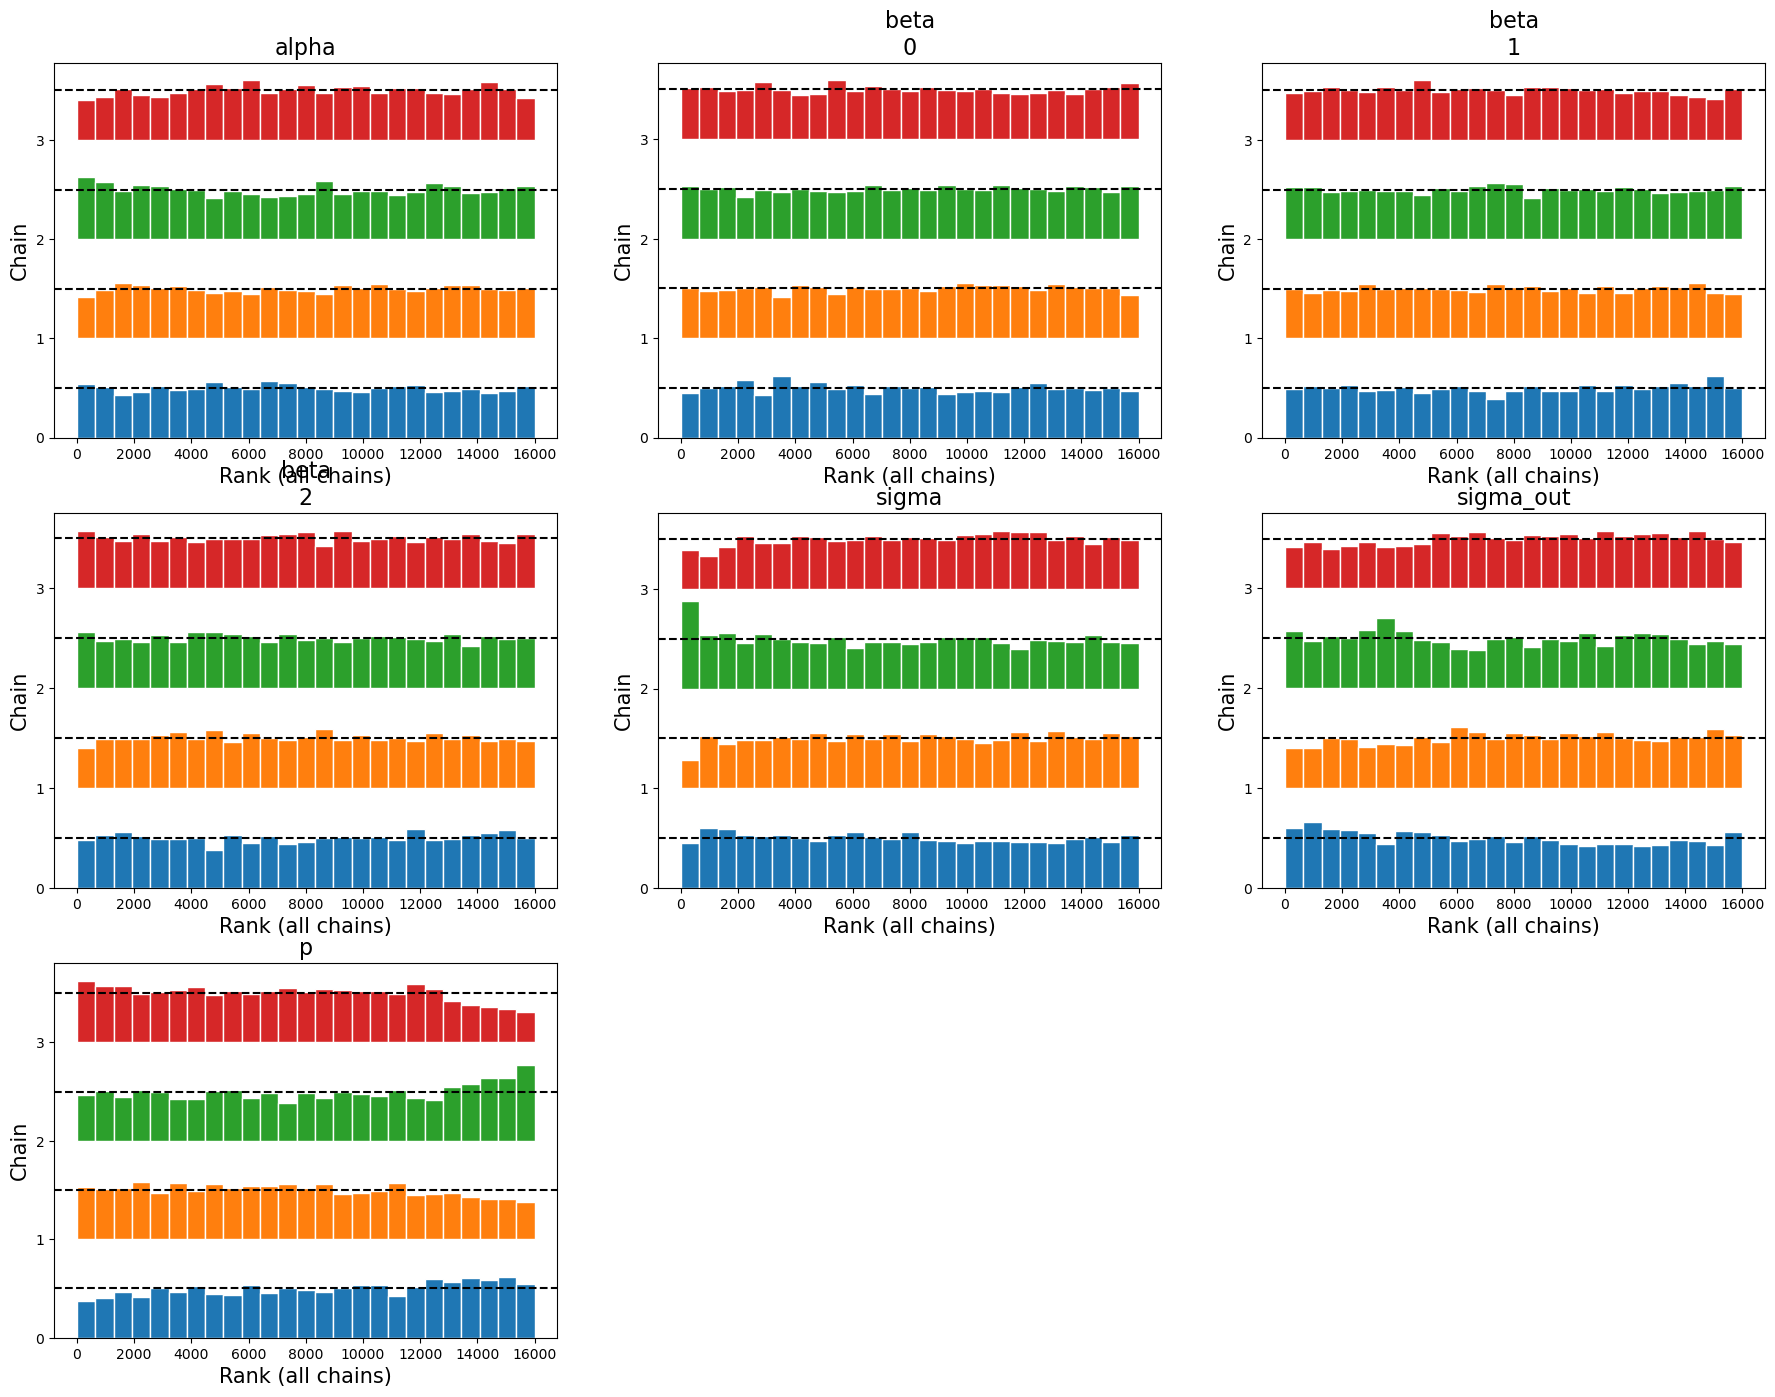

In [166]:
degree = 3
varnames = ["~mu","~is_outlier"]  # all variables except mu
az.plot_rank(outlier_inferences[degree-1], varnames)
az.summary(outlier_inferences[degree-1], varnames)

***Normal and Student-T likelihood***
For all normal and student T models, r-hat values equal 1 or 1.1, which is acceptable, and the effective sample size (ess) values are a few thousand. Also, rank plots are relatively uniformly distributed, meaning the sampler worked as expected. 

***Outlier Detection likelihood***

However, we encountered some problems with the outlier detection model. On a higher degree, the PYMC sampler was not working as expected, and the chains were not going through all the values. Therefore, we increased the number of sample draws and tunes to 4000. As a result, PYMC is working fine on degree 3 or lower. Maybe we could solve the problem by increasing the number of draws and tunes. However, this is computationally expensive, so we only consider outlier detection models with degree 3 or less. 

(Note: We are dropping the degrees above three so easily because the deviance and PSIS values increase as degrees increase, which we will see later. The reason is that the sample size is small, and I believe that the outlier detection likelihood model has already started overfitting above degree 3.)

### Model Comparisons

#### Deviance Comparisons

Now we have proved that our sampler is working fine on the models except for high-degree outlier detection models, we will compare the deviance of each model. 

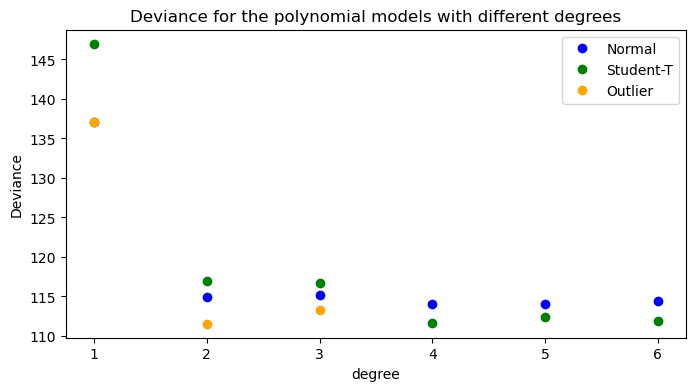

In [186]:
plt.figure(figsize=(8, 4))
plt.title(f'Deviance for the polynomial models with different degrees')
plt.plot(degrees, -2 * np.array(normal_lppds), 'ko', color = 'b', label = 'Normal')
plt.plot(degrees, -2 * np.array(t_lppds), 'ko', color = 'g', label = 'Student-T')
plt.plot(degrees[:3], -2 * np.array(outlier_lppds[:3]), 'ko', color = 'orange', label = 'Outlier')
plt.xlabel('degree')
plt.ylabel('Deviance')
plt.legend()

plt.show()

As we observe from the plots, the outlier model with degree 2 and the normal model with the Student-T model with degree 4 has the lowest deviance. In this context, these two models are fitting the data the best. Now, we can continue plotting the posterior samples for these two models. 

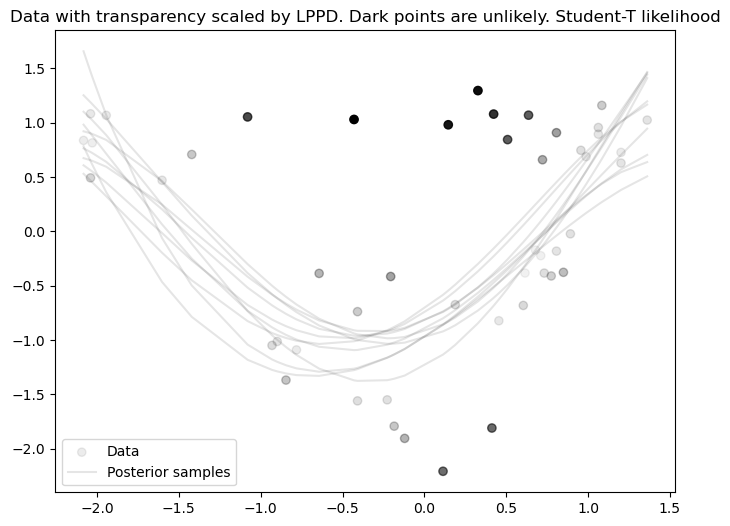

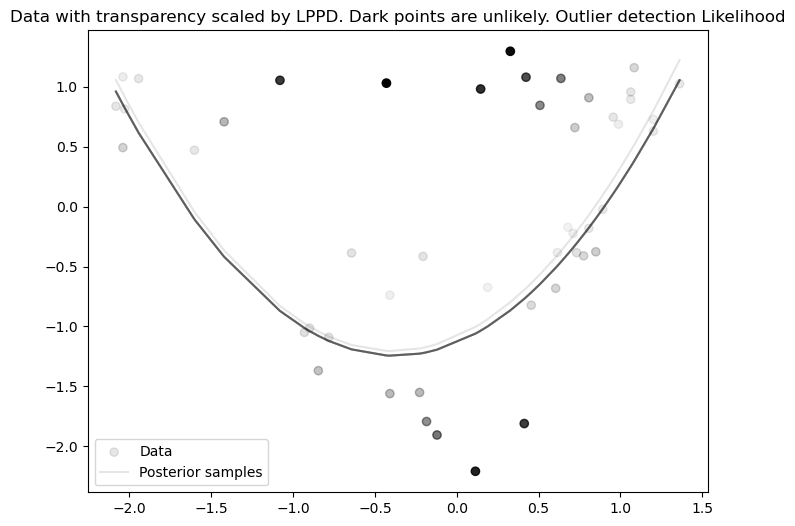

In [187]:
### Degree 4 Student-T model
t_inference = t_inferences[3]  
weights = -lppd(t_inference)[1]
alpha = (weights - weights.min()) / (weights.max() - weights.min()) * 0.95 + 0.05

plt.figure(figsize=(8, 6))
plt.title('Data with transparency scaled by LPPD. Student-T likelihood')
plt.scatter(data_x_std, data_y_std, alpha=alpha, color='k', label='Data')
plt.plot(data_x_std, t_inference.posterior.mu[0, 0, :].transpose(), 'k-', alpha=0.1, label='Posterior samples')
plt.plot(data_x_std, t_inference.posterior.mu[0, 1:10, :].transpose(), 'k-', alpha=0.1)
plt.legend()
plt.show()

### Degree 2 Outlier detector model
outlier_inference = outlier_inferences[1]  
weights = -lppd(outlier_inference)[1]
alpha = (weights - weights.min()) / (weights.max() - weights.min()) * 0.95 + 0.05

plt.figure(figsize=(8, 6))
plt.title('Data with transparency scaled by LPPD. Outlier detection Likelihood')
plt.scatter(data_x_std, data_y_std, alpha=alpha, color='k', label='Data')
plt.plot(data_x_std, outlier_inference.posterior.mu[0, 0, :].transpose(), 'k-', alpha=0.1, label='Posterior samples')
plt.plot(data_x_std, outlier_inference.posterior.mu[0, 1:10, :].transpose(), 'k-', alpha=0.1)
plt.legend()
plt.show()

***This code is modified from: CS146 Session 11 - [6.2] Model comparison 2: Theory - LPPD discussion workbook - Log-pointwise-predictive-density (LPPD)***


Comparing the two plots, the Student-T likelihood model has a high variance. Conversely, the outlier detector model has a minimal variance, and the result is almost identical to the Student-T model. In this case, we would prefer the outlier detector model because it is less complex with a small degree, but the deviance is slightly smaller than the student-t model. 

Furthermore, we observe that the points have similar lppds. This means these two models expect the same points and are surprised by the same points (dark points). 

Now, we compared the fitness of the models with deviance; we can move to the predictive powers of each model by computing the PSIS-LOO-CV values. 

#### PSIS-LOO-CV comparisons

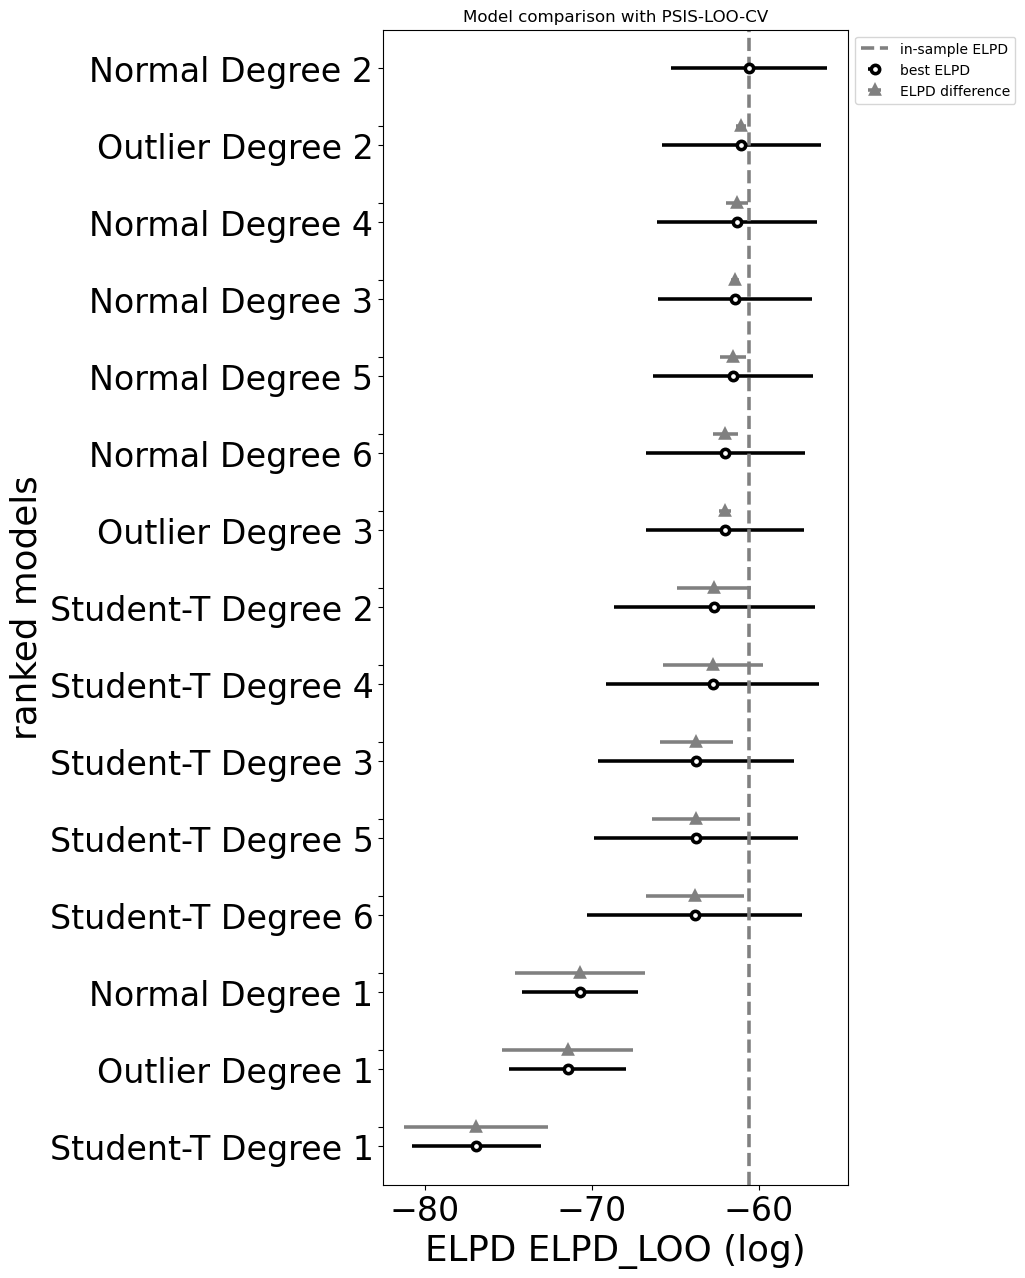

In [188]:
inferences = {'Normal Degree 1': normal_inferences[0], 'Normal Degree 2': normal_inferences[1],
              'Normal Degree 3': normal_inferences[2], 'Normal Degree 4': normal_inferences[3], 
              'Normal Degree 5': normal_inferences[4], 'Normal Degree 6': normal_inferences[5],
              'Student-T Degree 1': t_inferences[0], 'Student-T Degree 2': t_inferences[1],
              'Student-T Degree 3': t_inferences[2],'Student-T Degree 4': t_inferences[3],
              'Student-T Degree 5': t_inferences[4],'Student-T Degree 6': t_inferences[5],
              'Outlier Degree 1': outlier_inferences[0],'Outlier Degree 2': outlier_inferences[1],
              'Outlier Degree 3': outlier_inferences[2]}

df = az.compare(inferences, ic='loo')
az.plot_compare(df)

plt.title('Model comparison with PSIS-LOO-CV')
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')
plt.legend(['in-sample ELPD', 'best ELPD', 'ELPD difference', 'ELPD'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

***This code is modified from: "CS146 Session 12 - [7.1] Model comparison 3: Practice - 
Model comparison workbook 3 - Linear regression on obesity data"***

The plot suggests that the normal likelihood model with degree 2 has the best PSIS-LOO-CV value, meaning it has the highest predictive power. Even though Student-T degree 4 fits the data well, the predictive power is small with high variance. Moreover, the 95% credible interval includes the mean PSIS-LOO-CV value of normal likelihood degree 2, meaning it has the same predictive power in some cases. However, we will still prefer the normal likelihood model for prediction. 

We can continue plotting these two models posterior predictive with 95% highest density interval. 

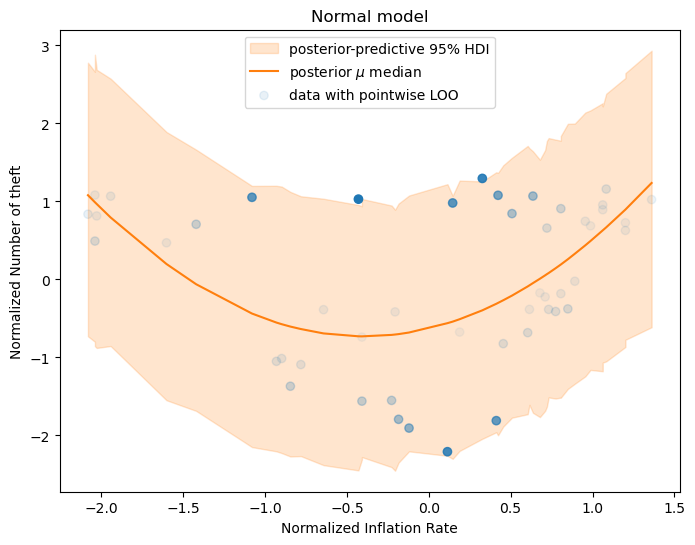

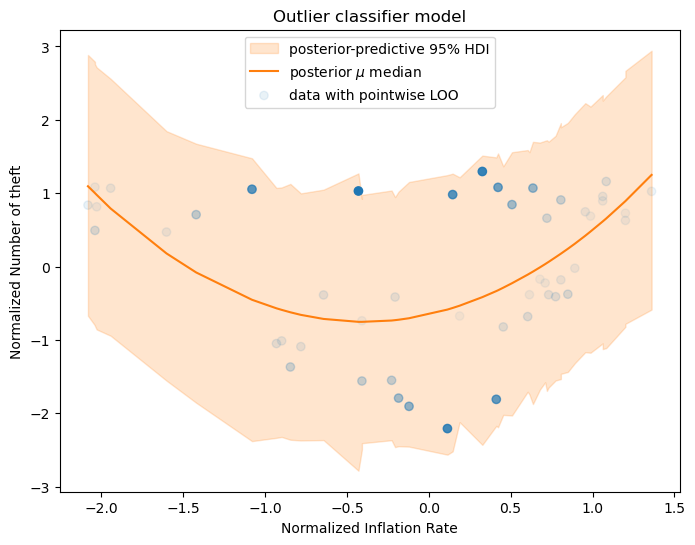

In [189]:
plot_posterior_predictive_hdi(normal_inferences[1])
plt.title('Normal model')
plot_posterior_predictive_hdi(outlier_inferences[1])
plt.title('Outlier classifier model')
plt.show()

These two models have very similar shape and 95% HDI. Also, the pointwise LOO values are identical.

### Conclusion

Based on the model fitness and predictive power, I would choose outlier detection likelihood model with degree 2. The story of the data is not appropriate for predicting future, but our outlier detection model performs decently in both cases. Thus, we would prefer outlier detection likelihood with degree 2.

***Policy for the use of AI tools at MU***

I have not used AI tools for coding or calculating, but I asked a few relevant questions, such as the difference between deviance and PSIS. 
